#### Here is the code for atomized moran squirrels. Essentially, think of it as follows: we have an infinitely large population of size normalized to 1. There are two types of individuals: $A$ and $B_T$, where type A has constant fitness equal to 1, and $B_T$ has fitness $\beta >1$ if its age is $\ge T$ and 0 otherwise. Every day, some fraction of the population is chosen to reproduce, with probability proportional to fitness.  Then, we uniformly select those to replace. This process iterates. 

#### This looks a lot like the atomizedMoranSquirrels, and the main difference is that now, survival probability is not uniform. Instead, $A$ types will have susceptibility parameter $1$, while $B_T$ types have susceptiblility parameter $u < 1$. In principle, $u\ge 1$ would be fine, but I want to help out the $B$ squirrels a little more. 

In [1]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [291]:
def prob_A_type_dies(current_pop, u):
    n_A = current_pop[0]
    n_B = sum(current_pop) - n_A
    p = n_A/(n_A + u*n_B)
    
    return p



def survival_matrix(current_pop, u):
    surv_mat = zero_matrix(QQ, N)
    for i in range(N):
        surv_mat[i,i] = s
        
    return surv_mat


def age_up_matrix(N):
    age_up_mat = zero_matrix(QQ, N)
    
    age_up_mat[0, 0] = 1
    
    for i in range(1, N - 1):
        age_up_mat[i+1, i] = 1
    
    age_up_mat[-1, -1] = 1
    
    return age_up_mat

In [306]:
def num_fertile_A(current_pop):
    return current_pop[0]

def num_fertile_B(current_pop):
    return current_pop[-1]

def A_reproduction_probability(current_pop, beta):
    return num_fertile_A(current_pop)/(num_fertile_A(current_pop) + beta*num_fertile_B(current_pop))

def kill_someone(current_pop, surv_mat):
    return surv_mat*current_pop

def birth_someone_and_age_up(current_pop, A_rep_prob, surv_mat, age_up_mat, s):
    num_to_generate = (1 - s)*sum(current_pop)
    
    current_pop = kill_someone(current_pop, surv_mat)
    
    current_pop = age_up_mat*current_pop
    current_pop[0] += A_rep_prob*num_to_generate
    current_pop[1] += (1 - A_rep_prob)*num_to_generate
    
    return current_pop


In [307]:
def expected_day_of_squirrels(current_pop, beta, s, surv_mat = None, age_up_mat = None):
    
    N = len(current_pop)
    if surv_mat == None:
        surv_mat = survival_matrix(N, s)
    if age_up_mat == None:
        age_up_mat = age_up_matrix(N)
    
    p = A_reproduction_probability(current_pop, beta)
#    current_pop = kill_someone(current_pop, surv_mat)
    current_pop = birth_someone_and_age_up(current_pop, p, surv_mat, age_up_mat, s)
    
    return current_pop.n()

In [553]:
current_pop = vector((1, 1, 0, 0))
for i in tqdm(range(2000)):
    current_pop = expected_day_of_squirrels(current_pop, 9/4, 2/3)
current_pop

  0%|          | 0/2000 [00:00<?, ?it/s]

(1.44558339999403, 0.184805533335321, 0.123203688890214, 0.246407377780427)

In [557]:
A_reproduction_probability(current_pop, 9/4)

0.722791699997019

In [559]:
current_pop[-1]*9/4 + current_pop[0]

1.99999999999999

#### Look at this: the B type contingent of the population has stable age distribution $(b, bs, bs^2, , \ldots, bs^{T-1}, \sum\limits_{t = T}^\infty bs^t)$, where $b = 1-s$. 

In [555]:
current_pop[1]/sum(current_pop[1:]) #notice this equals 1 - s. 

0.333333333333333

In [520]:
sum([((2/3)^t)*current_pop[1] for t in range(2, 200)])

0.883510438581125

In [415]:
current_pop = expected_day_of_squirrels(current_pop, 1, 1/2)
current_pop

(1.60714285714286, 0.142857142857143, 0.250000000000000)

In [461]:
def asymptotic_proportion_of_type_A(T, beta, s):
    
    #initialize data -- start with equal num of A types and B types. 
    N = T + 2
    current_pop = zero_vector(QQ, N)
    current_pop[0] = 1/2
    current_pop[1] = 1/2
    
    #build necessary survival and ageing matrices
    surv_mat = survival_matrix(N, s)
    age_up_mat = age_up_matrix(N)
    
    
    counter = 0
    while (current_pop[0] > 10^(-2) and current_pop[0] < 1 - 10^(-2)):
        counter += 1
        stability_check = current_pop[0]
        current_pop = expected_day_of_squirrels(current_pop, beta, s, surv_mat, age_up_mat)
        if stability_check == current_pop[0] and counter > 100:
            return current_pop[0]
            break
    if current_pop[0] < 10^(-2):
        return 0
    if current_pop[0] > 1 - 10^(-2):
        return 1

In [443]:
def get_function_for_root_finding(T, s):
    def f(beta):
        if asymptotic_proportion_of_type_A(T, beta, s) == 0:
            return -1
        elif asymptotic_proportion_of_type_A(T, beta, s) == 1:
            return 1
        else:
            return 0
        
    return f

In [451]:
def find_beta_with_mixed_eq(T, s):
    f = get_function_for_root_finding(T, s)
    beta_tilde = bisection(f, 1, 1100)
    return beta_tilde.n()

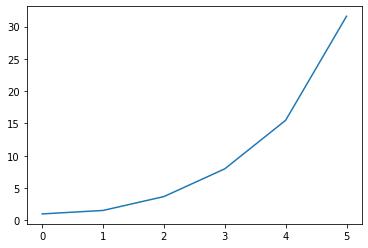

In [457]:
plt.plot(appreciation_vec)

In [470]:
asymptotic_proportion_of_type_A(3, 1600, 1/4)

1

In [460]:
appreciation_vec = [1]
for t in range(1, 10):
    beta_tilde = find_beta_with_mixed_eq(t, 1/4)
    appreciation_vec.append(beta_tilde)
    print(beta_tilde)
    

3.68310546875000
15.4887695312500
Bisection method fails.


AttributeError: 'NoneType' object has no attribute 'n'

In [453]:
def bisection(f,a,b,N = 10):
    '''Approximate solution of f(x)=0 on interval [a,b] by bisection method.

    Parameters
    ----------
    f : function
        The function for which we are trying to approximate a solution f(x)=0.
    a,b : numbers
        The interval in which to search for a solution. The function returns
        None if f(a)*f(b) >= 0 since a solution is not guaranteed.
    N : (positive) integer
        The number of iterations to implement.

    Returns
    -------
    x_N : number
        The midpoint of the Nth interval computed by the bisection method. The
        initial interval [a_0,b_0] is given by [a,b]. If f(m_n) == 0 for some
        midpoint m_n = (a_n + b_n)/2, then the function returns this solution.
        If all signs of values f(a_n), f(b_n) and f(m_n) are the same at any
        iteration, the bisection method fails and return None.

    Examples
    --------
    >>> f = lambda x: x**2 - x - 1
    >>> bisection(f,1,2,25)
    1.618033990263939
    >>> f = lambda x: (2*x - 1)*(x - 3)
    >>> bisection(f,0,1,10)
    0.5
    '''
    if f(a)*f(b) > 0:
        print("Bisection method fails.")
        return None
    if f(a)*f(b) == 0:
        if f(a) == 0:
            print('Found exact solution')
            return a
        if f(b) == 0:
            print('Found exact solution')
            return b
    a_n = a
    b_n = b
    for n in range(1,N+1):
#        print('starting round {}'.format(n))
        m_n = (a_n + b_n)/2
        f_m_n = f(m_n)
        if f(a_n)*f_m_n < 0:
            a_n = a_n
            b_n = m_n
        elif f(b_n)*f_m_n < 0:
            a_n = m_n
            b_n = b_n
        elif f_m_n == 0:
            print("Found exact solution.")
            return m_n
        else:
            print("Bisection method fails.")
            return None
    return (a_n + b_n)/2